In [1]:
import cv2 as cv
from skimage import feature
from skimage import io
import os
import numpy as np

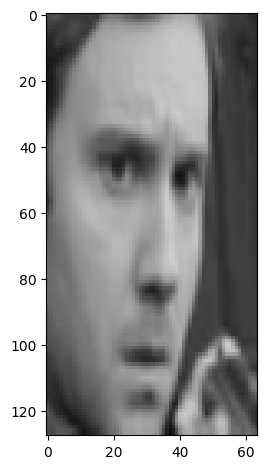

In [2]:
test = io.imread('./data/train/0/0.png')
io.imshow(cv.resize(test, (64, 128)))

In [3]:
label_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [4]:
def read_data(path, percent=1.0):
  labels = []
  images = []
  listDir = os.listdir(path)
  print('Summary ')
  for dir_name in listDir:
    label = label_names[int(dir_name)]
    img_list = os.listdir(path + f"/{dir_name}")

    print(f"\t{label}: {round(len(img_list) * percent)} images")
    
    for img_name in img_list[:round(len(img_list) * percent)]:
      labels.append(dir_name)
      images.append(io.imread(f"{path}/{dir_name}/{img_name}"))

  return labels, images

In [5]:
train_labels, train_images = read_data('data/train', 0.5)

Summary 
	angry: 1998 images
	disgust: 218 images
	fear: 2048 images
	happy: 3608 images
	sad: 2415 images
	surprise: 1586 images
	neutral: 2482 images


In [6]:
len(train_labels)

14355

In [7]:
test_labels, test_images = read_data('data/test', 0.5)

Summary 
	angry: 246 images
	disgust: 28 images
	fear: 264 images
	happy: 440 images
	sad: 297 images
	surprise: 208 images
	neutral: 313 images


In [8]:
len(test_labels)

1796

In [9]:
def compute_hog_feature(imgs):
    features = []
    for img in imgs:
        resized_ing = cv.resize(img, (64, 128))
        (hog, hog_image) = feature.hog(resized_ing, orientations=9,
        pixels_per_cell=(8, 8), cells_per_block=(2, 2),
        block_norm='L2-Hys', visualize=True, transform_sqrt=True)
        features.append(hog)
    return features

In [10]:
train_freatures = compute_hog_feature(train_images)

In [11]:
test_freatures = compute_hog_feature(test_images)

# HOG

In [12]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=3000)
logistic_model.fit(X=train_freatures, y=train_labels)

LogisticRegression(max_iter=3000)

In [13]:
logistic_model.score(test_freatures, test_labels)

0.43318485523385303

# KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(train_freatures, train_labels)

KNeighborsClassifier(n_neighbors=7)

In [15]:
knn_model.score(train_freatures, train_labels)

0.5850923023336816

In [23]:
knn_model.score(test_freatures, test_labels)

0.4214922048997773

# Neural network

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X_train = np.array(train_freatures)
y_train = np.array(label_encoder.fit_transform(train_labels))  
X_test = np.array(test_freatures)
y_test = np.array(label_encoder.fit_transform(test_labels))

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

# Create a TensorDataset to combine the input data and labels
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Define the batch size for the DataLoader
batch_size = 32

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
import torch.nn as nn

class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out

In [29]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

input_size = 3780
num_classes = 7

fc_model = FullyConnectedNet(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.002)

num_epochs = 20

for epoch in range(num_epochs):
    fc_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:  # Assuming train_loader provides mini-batches
        inputs = inputs.to(torch.float32)

        outputs = fc_model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Step 5: Evaluation
        fc_model.eval()
        with torch.no_grad():
            val_outputs = fc_model(inputs)
            val_loss = criterion(val_outputs, labels)
            val_predictions = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_score(labels, val_predictions)

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train-Loss: {running_loss:.4f}, Val-Loss: {val_loss.item():.4f}, Accuracy: {val_accuracy:.4f}"
    )


Epoch 1/20, Train-Loss: 817.3166, Val-Loss: 1.7405, Accuracy: 0.4211
Epoch 2/20, Train-Loss: 790.2101, Val-Loss: 1.6794, Accuracy: 0.4737
Epoch 3/20, Train-Loss: 779.0002, Val-Loss: 1.8696, Accuracy: 0.3158
Epoch 4/20, Train-Loss: 771.3488, Val-Loss: 1.5529, Accuracy: 0.6842
Epoch 5/20, Train-Loss: 765.2770, Val-Loss: 1.6304, Accuracy: 0.5263
Epoch 6/20, Train-Loss: 761.0631, Val-Loss: 1.6770, Accuracy: 0.4737
Epoch 7/20, Train-Loss: 758.8628, Val-Loss: 1.6315, Accuracy: 0.5263
Epoch 8/20, Train-Loss: 752.4185, Val-Loss: 1.7165, Accuracy: 0.4211
Epoch 9/20, Train-Loss: 749.4571, Val-Loss: 1.5579, Accuracy: 0.5789
Epoch 10/20, Train-Loss: 748.4522, Val-Loss: 1.6125, Accuracy: 0.5263
Epoch 11/20, Train-Loss: 741.8176, Val-Loss: 1.6361, Accuracy: 0.5263
Epoch 12/20, Train-Loss: 738.6938, Val-Loss: 1.5330, Accuracy: 0.5789
Epoch 13/20, Train-Loss: 735.9417, Val-Loss: 1.7259, Accuracy: 0.4211
Epoch 14/20, Train-Loss: 730.9470, Val-Loss: 1.6119, Accuracy: 0.5789
Epoch 15/20, Train-Loss: 728.

In [30]:
num_correct = 0
num_samples = 0
fc_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(torch.float32)

        scores = fc_model(x)
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)
    
    print(f"{num_correct}/{num_samples} -> {float(num_correct)/float(num_samples)*100:.2f}%")

805/1796 -> 44.82%
